In [1]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
# Read the bad senders
with open('bad_sender.csv', 'r') as bad_s:
    bad_s_csv = csv.reader(bad_s)
    next(bad_s_csv)  # Skip the first row
    bad_senders = [int(row[0]) for row in bad_s_csv]


num_bad_senders = len(bad_senders)
# Calculate the value for bad nodes
bad_node_value = 1.0 / num_bad_senders

print(bad_node_value)

0.05


In [3]:
# Create a directed multi-graph
graph = nx.MultiDiGraph()

# Read the payments and add edges to the graph
with open('Payments.csv', 'r') as payments:
    payments_csv = csv.reader(payments)
    next(payments_csv)  # Skip the first row
    for row in payments_csv:
        sender = int(row[0])
        receiver = int(row[1])
        amount = float(row[2])
        graph.add_edge(sender, receiver, weight=amount)

# Assign values to nodes
for node in graph.nodes():
    if node in bad_senders:
        graph.nodes[node]['value'] = bad_node_value
    else:
        graph.nodes[node]['value'] = 0.0

# Print the list of bad senders
print("List of bad senders:", bad_senders)

print("Bad nodes and their associated value")
# Print bad nodes and their associated values
for node in graph.nodes(data=True):
    if node[0] in bad_senders:
        print(f"Node: {node[0]}, Value: {node[1]['value']}")

number_nodes = graph.number_of_nodes()
# Check the number of nodes and edges
print("Number of nodes: ", number_nodes)
print("Number of edges: ", graph.number_of_edges())

List of bad senders: [1303, 1259, 1562, 1147, 1393, 1031, 1210, 1042, 1048, 1256, 1668, 1161, 1007, 1034, 1836, 1099, 1489, 1821, 1076, 1944]
Bad nodes and their associated value
Node: 1259, Value: 0.05
Node: 1147, Value: 0.05
Node: 1393, Value: 0.05
Node: 1210, Value: 0.05
Node: 1042, Value: 0.05
Node: 1256, Value: 0.05
Node: 1668, Value: 0.05
Node: 1007, Value: 0.05
Node: 1034, Value: 0.05
Node: 1099, Value: 0.05
Node: 1076, Value: 0.05
Node: 1944, Value: 0.05
Node: 1048, Value: 0.05
Node: 1031, Value: 0.05
Node: 1562, Value: 0.05
Node: 1821, Value: 0.05
Node: 1161, Value: 0.05
Node: 1489, Value: 0.05
Node: 1303, Value: 0.05
Node: 1836, Value: 0.05
Number of nodes:  799
Number of edges:  130535


In [4]:
# Normalize the weights of the outgoing edges for each node
for node in graph.nodes():
    # Get the outgoing edges for the node
    outgoing_edges = graph.out_edges(node, data=True)
    
    # Calculate the total weight of the outgoing edges
    total_weight = sum(edge[2]['weight'] for edge in outgoing_edges)
    
    # Normalize the weights of the outgoing edges
    for _, _, edge_data in outgoing_edges:
        edge_data['weight'] /= total_weight

first_node = list(graph.nodes())[0]
out_edges = graph.out_edges(first_node, data=True)
print('Prinitng the weight of outgoing edges of one node')
for _, _, edge_data in out_edges:
        print(edge_data['weight'])

Prinitng the weight of outgoing edges of one node
0.0006263862564774265
0.0006027410673986083
0.0005724528273514678
0.0006138739045386246
0.000847032267375461
0.0009051704168844345
0.0008620745781887888
0.0009215667901939874
0.0006781307875831715
0.0006783242250826323
0.0008571215601104917
0.0006705154586570334
0.0008735026620385082
0.0005820228931142619
0.0008702142245476758
0.0006067930739662594
0.0008746531061142483
0.000965813072965373
0.0005818294556148011
0.0006363941018442631
0.0008660705896908065
0.0008603489120751787
0.0008713748495444402
0.0006156759275599167
0.0009329948740437067
0.0008538840272247805
0.0008651186735750392
0.0008769845370288013
0.0006092212236305428
0.0006213874242545202
0.0006118529917153112
0.0005766422763529463
0.0005737865280056445
0.000877177974528262
0.0006349331396772835
0.000851980194993246
0.0006211787153735231
0.0008601707459572542
0.000665755878078197
0.0008717617245433616
0.0005909210180894554
0.000857503344648901
0.0006063858371252895
0.00060514

In [5]:
# Initialize two dictionaries to store the values of nodes
fraud_values = {node: data['value'] for node, data in graph.nodes(data=True)}

alpha = 0.75
cnvrg_threshold = 0.0001

for i in range(1000):
    updated_values = {node: 0 for node in graph.nodes()}

    # Iterate over all nodes
    for node in graph.nodes():
        # Get the outgoing edges for the node
        outgoing_edges = graph.out_edges(node, data=True)
        # Iterate over the outgoing edges
        for _, target_node, edge_data in outgoing_edges:
            
            # Calculate the value transfer
            value_transfer = fraud_values[node] * edge_data['weight']
            # Update the value of the target node
            graph.nodes[target_node]['value'] += value_transfer

    # Update the values of nodes and apply the damping factor
    for node in graph.nodes():
        if node in bad_senders:
            graph.nodes[node]['value'] = alpha*graph.nodes[node]['value'] + (1 - alpha)/num_bad_senders
            updated_values[node] = graph.nodes[node]['value']
        else:
            graph.nodes[node]['value'] = alpha*graph.nodes[node]['value'] 
            updated_values[node] = graph.nodes[node]['value']

    # Calculate the absolute differences
    differences = [abs(a - b) for a, b in zip(fraud_values.values(), updated_values.values())]

    # Find the maximum difference
    max_difference = max(differences)

    # Update the fraud_values dictionary for the next iteration
    fraud_values = updated_values.copy()
    sum_score = sum(fraud_values.values())
    for node in graph.nodes():
        graph.nodes[node]['value'] /= sum_score

    if max_difference < cnvrg_threshold:
        print(f'Converged in iteration number {i}')
        break

        
print('*****************************************')
#print(f"Sum of values of all nodes after convergence: {sum(fraud_values.values())}")

min_value = graph.nodes[bad_senders[0]]['value']
min_node = bad_senders[0]

# Iterate over the rest of the bad senders
for node in bad_senders[1:]:
    # If the current node's value is less than the minimum value, update the minimum
    if graph.nodes[node]['value'] < min_value:
        min_value = graph.nodes[node]['value']
        min_node = node

print(f"The bad node with the least value is {min_node} with a value of {min_value}.\n")

Converged in iteration number 83
*****************************************
The bad node with the least value is 1303 with a value of 0.004506639445303334.



In [6]:
# Initialize the list
updated_bad_nodes = []

# Iterate over all nodes in the graph
for node in graph.nodes():
    # If the node's value is higher than min_value, add it to the list
    if graph.nodes[node]['value'] >= min_value:
        updated_bad_nodes.append(node)

print("List of updated bad nodes")
# Now updated_bad_nodes contains all nodes with value higher than min_value
print(updated_bad_nodes)
print(f'Total number of bad nodes {len(updated_bad_nodes)}')

List of updated bad nodes
[1309, 1011, 1259, 1147, 1393, 1039, 1210, 1005, 1042, 1256, 1668, 1007, 1034, 1099, 1076, 1944, 1048, 1205, 1276, 1138, 1079, 1037, 1049, 1013, 1084, 1480, 1016, 1356, 1108, 1246, 1031, 1114, 1562, 1144, 1283, 1103, 1021, 1201, 1050, 1330, 1088, 1038, 1193, 1139, 1067, 1175, 1296, 1239, 1230, 1311, 1086, 1094, 1122, 1258, 1626, 1173, 1041, 1043, 1381, 1226, 1249, 1821, 1369, 1161, 1489, 1303, 1836]
Total number of bad nodes 67


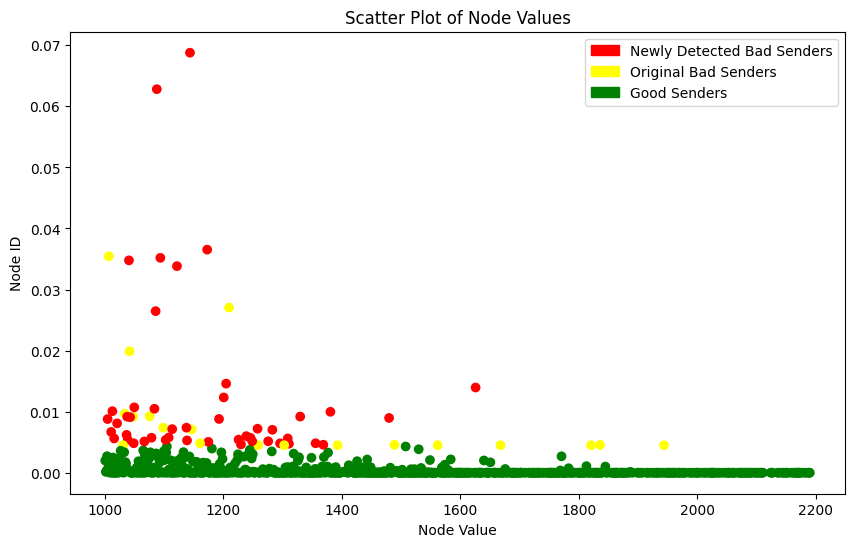

In [7]:
# Create lists for node ids and their values
node_ids = [node for node in graph.nodes()]
node_values = [graph.nodes[node]['value'] for node in graph.nodes()]

# Create a list for colors
colors = ['yellow' if node in bad_senders else 'green' if graph.nodes[node]['value'] < min_value else 'red' for node in graph.nodes()]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(node_ids, node_values, c=colors)
plt.xlabel('Node Value')
plt.ylabel('Node ID')
plt.title('Scatter Plot of Node Values')

# Create a legend
red_patch = mpatches.Patch(color='red', label='Newly Detected Bad Senders')
yellow_patch = mpatches.Patch(color='yellow', label='Original Bad Senders')
green_patch = mpatches.Patch(color='green', label='Good Senders')
plt.legend(handles=[red_patch, yellow_patch, green_patch])

plt.show()